In [1]:
%pip install vnstock gym_anytrading -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

from time import time
from enum import IntEnum
from vnstock import Vnstock
from typing import Tuple, List, Dict

from gymnasium import spaces
import gymnasium as gym

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy


import warnings
warnings.filterwarnings('ignore')

# Lấy danh sách mã cổ phiếu từ Vnstock
stock = Vnstock().stock(symbol = 'VN30F1M', source='VCI')

df = stock.listing.all_symbols()

tickers = df['symbol'].tolist()

print(tickers)
print(f"Có {len(tickers)} mã cổ phiếu trong danh sách VN30F1M")

2025-03-26 21:04:29 - vnstock.common.data.data_explorer - INFO - Không phải là mã chứng khoán, thông tin công ty và tài chính không khả dụng.


['YTC', 'YEG', 'YBM', 'YBC', 'XPH', 'XMP', 'XMD', 'XMC', 'XLV', 'XHC', 'XDH', 'XDC', 'X77', 'X26', 'X20', 'WTC', 'WSS', 'WSB', 'WCS', 'VXT', 'VXP', 'VXB', 'VWS', 'VW3', 'VVS', 'VVN', 'VUA', 'VTZ', 'VTX', 'VTV', 'VTS', 'VTR', 'VTQ', 'VTP', 'VTO', 'VTM', 'VTL', 'VTK', 'VTJ', 'VTI', 'VTH', 'VTG', 'VTE', 'VTD', 'VTC', 'VTB', 'VTA', 'VST', 'VSP', 'VSN', 'VSM', 'VSI', 'VSH', 'VSG', 'VSF', 'VSE', 'VSC', 'VSA', 'VRG', 'VRE', 'VRC', 'VQC', 'VPW', 'VPS', 'VPR', 'VPI', 'VPH', 'VPG', 'VPD', 'VPC', 'VPB', 'VPA', 'VOS', 'VOC', 'VNZ', 'VNY', 'VNX', 'VNT', 'VNS', 'VNR', 'VNP', 'VNM', 'VNL', 'VNI', 'VNH', 'VNG', 'VNF', 'VNE', 'VND', 'VNC', 'VNB', 'VNA', 'VMT', 'VMS', 'VMK', 'VMI', 'VMG', 'VMD', 'VMC', 'VMA', 'VLW', 'VLP', 'VLG', 'VLF', 'VLC', 'VLB', 'VLA', 'VKP', 'VKD', 'VKC', 'VJC', 'VIX', 'VIW', 'VIT', 'VIS', 'VIR', 'VIP', 'VIN', 'VIM', 'VIH', 'VIG', 'VIF', 'VIE', 'VID', 'VIC', 'VIB', 'VHM', 'VHL', 'VHI', 'VHH', 'VHG', 'VHF', 'VHE', 'VHD', 'VHC', 'VGV', 'VGT', 'VGS', 'VGR', 'VGP', 'VGL', 'VGI', 'VGG'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Lấy dữ liệu chứng khoán FPT từ VCI
stock = Vnstock().stock(symbol='FPT', source='VCI')
df = stock.quote.history(start='2017-01-01', end='2024-01-01')

#Đổi tên cột thoả mãn với gym anytrading
df.rename(columns={
    'time': 'Date',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])  # Chuyển đổi sang định dạng datetime
df.set_index('Date', inplace=True)  # Đặt cột Date làm index
df


,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,11.33,11.50,11.33,11.47,1013070
2017-01-04,11.46,11.69,11.43,11.57,1022560
2017-01-05,11.56,11.61,11.53,11.53,613870
2017-01-06,11.56,11.64,11.50,11.50,799750
2017-01-09,11.52,11.61,11.48,11.56,501610
...,...,...,...,...,...
2023-12-25,81.39,82.51,81.30,82.33,2019931
2023-12-26,82.76,84.56,82.68,83.36,3364283
2023-12-27,83.53,83.88,83.11,83.11,1359748


In [5]:
class Actions(IntEnum):
    """
    Định nghĩa các hành động mà môi trường có thể thực hiện
    """
    Sell = 2
    Buy = 1
    Hold = 0


class Positions(IntEnum):
    """
    Vị thế của môi trường
    """
    Short = 2
    Long = 1
    No_Position = 0

    def opposite(self):
        if self == Positions.Long:
            return Positions.Short
        else:
            return Positions.Long

In [6]:
class TradingEnv(gym.Env):
    metadata = {'render_modes': ['human'], 'render_fps': 3}
    
    def __init__(
        self, 
        df: pd.DataFrame,
        window_size: int, 
        frame_bound: tuple,
        initial_balance: int, # Số dư ban đầu
        max_shares: int, # Số lượng cổ phiếu nắm giữ tối đa cho cả
        render_mode = None
    ):
        assert render_mode is None or render_mode in self.metadata['render_modes']
        
        self.render_mode = render_mode
        self.window_size = window_size
        self.frame_bound = frame_bound
        self.initial_balance = initial_balance # Số dư ban đầu
        self.max_shares = max_shares 

        # Khởi tạo các giá trị chỉ số kỹ thuật
        self.df = self.add_technical_indicators(df)
        self.prices, self.signal_features = self._process_data()
        self.shape = (self.window_size, self.signal_features.shape[1])
        super().__init__()

        # Định nghĩa không gian hành động
        self.action_space = spaces.Discrete(len(Actions))
        
        self.observation_space = spaces.Box(
            low = - np.inf,
            high = np.inf,
            shape = self.shape,
            dtype = np.float32
        )
        
        # Episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._truncated = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None 
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None
        
        # Phí giao dịch
        self.trade_fee_bid_percent = 0.01 # Phí mua
        self.trade_fee_ask_percent = 0.005 # Phí bán

        # Khởi tạo các giá trị thống kê
        self._balance = None # Số dư hiện tại
        self._shares_held = None # Số lượng cổ phiếu đang nắm giữ (long)
        self._portfolio_value = None # Giá trị danh mục
        self._cost_basis = None # Giá vốn
        self._last_action = Actions.Hold.value # Hành động cuối cùng
        self._prev_portfolio_value = None # Giá trị danh mục trước
        self._peak_portfolio_value = 0 # Đỉnh giá trị danh mục
        
        self._position_size = 0 # Số lượng cổ phiếu đang nắm giữ (short)
        self._total_profit = 1.0 # Lợi nhuận tổng cộng
        
    def add_technical_indicators(self, df: pd.DataFrame):
        """
        Cập nhật các chỉ số kỹ thuật vào dữ liệu
        """
        def _calculate_rsi(prices: pd.Series, window_size: int =14, epsilon: float = 1e-10) -> pd.Series:
            """
            Tính chỉ số RSI
            Dùng để xác định xem một cổ phiếu có overbought hay oversold không
            
            RSI > 70: Overbought
            RSI < 30: Oversold
            RSI ~= 40-60: Neutral
            """
            delta = prices.diff()
            gain = (delta.where(delta > 0, 0)).fillna(0)
            loss = (-delta.where(delta < 0, 0)).fillna(0)
            avg_gain = gain.rolling(window = window_size).mean()
            avg_loss = loss.rolling(window = window_size).mean()
            rs = avg_gain / (avg_loss + epsilon)
            rsi = 100 - (100 / (1 + rs))
            return rsi

        def _calculate_macd(prices: pd.Series, short_window: int = 12, long_window: int = 26, signal_window: int = 9) -> Tuple[pd.Series, pd.Series]:
            """
            Tính chỉ số MACD
            Dùng để xác định xu hướng giá, tín hiệu mua bán và động lượng của tài sản
            """
            short_ema = prices.ewm(span= short_window, adjust = False).mean() # 12 phiên
            long_ema = prices.ewm(span = long_window, adjust = False).mean() # 26 phiên
            macd = short_ema - long_ema
            macd_signal = macd.ewm(span = signal_window, adjust = False).mean()
            return macd, macd_signal

        def _calculate_bollinger_bands(prices: pd.Series, window_size: int = 20) -> Tuple[pd.Series, pd.Series, pd.Series]:
            """
            Tính chỉ số Bollinger Bands
            Giúp đo lường độ biến động (volatility) của giá và xác định vùng quá mua/quá bán
            """
            sma = prices.rolling(window = window_size).mean() # 20 phiên
            std = prices.rolling(window = window_size).std()
            upper_band = sma + (std * 2)
            lower_band = sma - (std * 2)
            return upper_band, lower_band, sma

        def _calculate_atr(high: pd.Series, low: pd.Series, close: pd.Series, window_size: int = 14) -> pd.Series:
            """
            Chỉ Average True Range
            Đo lường biến động của giá, không chỉ ra hướng mà cho thấy biên độ giá dao động
            """
            tr1 = high - low
            tr2 = abs(high - close.shift())
            tr3 = abs(low - close.shift())
            tr = pd.DataFrame({'tr1': tr1, 'tr2': tr2, 'tr3': tr3}).max(axis = 1)
            atr = tr.rolling(window = window_size).mean()
            return atr

        def _calculate_volatility(prices: pd.Series, window_size: int =20) -> pd.Series:
            """
            Tính độ biến động của giá
            """
            log_returns = np.log(prices / prices.shift(1))
            return log_returns.rolling(window = window_size).std() * np.sqrt(252)

        # Cập nhật các chỉ số kỹ thuật
        df = df.copy()
        df['RSI'] = _calculate_rsi(df['Close'])
        df['MACD'], df['MACD_Signal'] = _calculate_macd(df['Close'])
        df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
        df['BB_Upper'], df['BB_Lower'], df['BB_Middle'] = _calculate_bollinger_bands(df['Close'])
        df['ATR'] = _calculate_atr(df['High'], df['Low'], df['Close'])
        df['Volatility'] = _calculate_volatility(df['Close'])
        df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
        df['SMA_20'] = df['Close'].rolling(window = 20).mean()
        df['SMA_50'] = df['Close'].rolling(window = 50).mean()

        if 'Volume' in df.columns:
            df['Volume_SMA_20'] = df['Volume'].rolling(window = 20).mean()
            df['Volume_Ratio'] = df['Volume'] / df['Volume'].rolling(window = 20).mean()

        df.fillna(0, inplace = True)
        
        return df

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        self.action_space.seed(int((self.np_random.uniform(0, seed if seed is not None else 1))))
        
        self._truncated = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.No_Position
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.0
        self._total_profit = 1.0
        self._first_rendering = True
        self.history = {}
        
        self._balance = self.initial_balance
        self._shares_held = 0
        self._cost_basis = 0.0
        self._last_trade_tick = 0
        self._last_action = Actions.Hold.value
        self._position_size = 0
        
        current_price = self.prices[self._current_tick]
        self._portfolio_value = self._balance + (self._shares_held * current_price)
        self._prev_portfolio_value = self._portfolio_value
        self._peak_portfolio_value = self._portfolio_value
        
        observation = self._get_observation()
        info = self._get_info()
        
        if self.render_mode == 'human':
            self._render_frame()
        
        return observation, info
    
    def step(self, action):
        self._truncated = False
        self._current_tick += 1
        self._last_action = action
    
        if self._current_tick == self._end_tick:
            self._truncated = True
    
        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward
    
        trade = False
        if action == Actions.Buy.value:
            if self._position == Positions.No_Position:
                self._position = Positions.Long
                trade = True
            elif self._position == Positions.Long:
                trade = True  # Scale up long position
            elif self._position == Positions.Short:
                self._position = Positions.No_Position  # Close short
                trade = True
        elif action == Actions.Sell.value:
            if self._position == Positions.No_Position:
                self._position = Positions.Short
                trade = True
            elif self._position == Positions.Short:
                trade = True  # Scale up short position
            elif self._position == Positions.Long:
                self._position = Positions.No_Position  # Close long
                trade = True
    
        self._update_profit(action)
    
        if trade:
            self._last_trade_tick = self._current_tick
    
        self._position_history.append(self._position)
        observation = self._get_observation()
        info = self._get_info()
        self._update_history(info)
    
        if self.render_mode == 'human':
            self._render_frame()
    
        return observation, step_reward, False, self._truncated, info
    
    def _get_info(self):
        # Tính portofolio value
        current_price = self.prices[self._current_tick]
        portfolio_value = self._balance + (self._shares_held * current_price)

        # Chuyển vị thế sang chuỗi
        if self._position == Positions.Long:
            pos_str = 'Long'
        elif self._position == Positions.Short:
            pos_str = 'Short'
        else:
            pos_str = 'No Position'

        # Thêm các chỉ số kỹ thuật vào log
        detailed_info = {
            'balance': self._balance,
            'shares_held': self._shares_held,
            'last_action': self._last_action,
            'position': pos_str,
            'cost_basis': self._cost_basis,
            'portfolio_value': portfolio_value,
            'total_reward': self._total_reward,
            'total_profit': self._total_profit,
        }

        if self._current_tick < len(self.signal_features):
            current_tick_data = self.signal_features[self._current_tick]
            indicator_names = [
                'Close', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist',
                'BB_Upper', 'BB_Middle', 'BB_Lower', 'ATR', 'Volatility',
                'LogReturn', 'SMA_20', 'SMA_50'
            ]
            if 'Volume' in self.df.columns:
                indicator_names += ['Volume', 'Volume_SMA_20', 'Volume_Ratio']

            indicators = {}
            for i, name in enumerate(indicator_names):
                if i < len(current_tick_data):
                    indicators[name] = current_tick_data[i]

            detailed_info.update(indicators)
        return detailed_info
    
    # Copy từ gym_anytrading
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]
    
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)
            
    def _render_frame(self):
        self.render()

    def render(self, mode='human'):
        def _plot_position(position, tick):
            color = None
            if position == Positions.Short:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
            if color:
                plt.scatter(tick, self.prices[tick], color=color, zorder=3)
    
        start_time = time()
    
        plt.cla()
    
        plt.plot(self.prices, label="Prices", zorder=1)
    
        for i in range(len(self._position_history)):
            position = self._position_history[i]
            # Only plot if not None
            if position is not None:
                _plot_position(position, i)

        plt.suptitle(
            f"Total Reward: {self._total_reward:.6f} ~ "
            f"Total Profit: {self._total_profit:.6f}"
        )
        plt.legend()
    
        end_time = time()
        process_time = end_time - start_time
        pause_time = (1 / self.metadata['render_fps']) - process_time
    
        pause_time = max(0, pause_time)
        plt.pause(pause_time)

    def render_all(self, title=None):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.plot(long_ticks, self.prices[long_ticks], 'go')

        if title:
            plt.title(title)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

    def close(self):
        plt.close()

    def save_rendering(self, filepath):
        plt.savefig(filepath)

    def pause_rendering(self):
        plt.show()
    
    def _process_data(self):
        raise NotImplementedError

    def _calculate_reward(self, action):
        raise NotImplementedError

    def _update_profit(self, action):
        raise NotImplementedError

    def max_possible_profit(self):
        raise NotImplementedError

In [7]:
class VnStockEnv(TradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.short_fee_percent = 0.001 # Phí bán khống

    def _process_data(self):
        """
        Improved data processing with better normalization techniques
        """
        prices = self.df.loc[:, 'Close'].to_numpy()
        prices = prices[self.frame_bound[0] - self.window_size : self.frame_bound[1]]

        # Prioritize medium and long-term indicators
        feature_columns = [
            'Close', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist',
            'BB_Upper', 'BB_Lower', 'BB_Middle', 'ATR', 'Volatility',
            'LogReturn', 'SMA_20', 'SMA_50' 
        ]
        if 'Volume' in self.df.columns:
            feature_columns += ['Volume_SMA_20', 'Volume_Ratio']

        # Extract features
        features = self.df[feature_columns].to_numpy()
        features = features[self.frame_bound[0] - self.window_size : self.frame_bound[1]]

        # Setup normalized features array
        normalized_features = np.zeros_like(features)

        # Use a longer lookback period for more stable normalization
        lookback = min(100, self.window_size * 2)  # More stable lookback period

        for i in range(features.shape[0]):
            for j in range(features.shape[1]):
                feature_name = feature_columns[j]
                value = features[i, j]

                # Improved normalization based on feature type
                if feature_name == 'RSI':
                    # RSI is already normalized between 0-100, so just rescale to -1 to 1
                    normalized_features[i, j] = (value - 50) / 50
                elif 'Ratio' in feature_name:
                    # Log-transform ratios for better distribution
                    normalized_features[i, j] = np.log1p(value) if value > 0 else 0
                elif 'Return' in feature_name:
                    # Clip returns to reasonable range and normalize
                    normalized_features[i, j] = np.clip(value, -0.1, 0.1) / 0.1
                else:
                    # Calculate rolling mean and std using only past data
                    start_idx = max(0, i - lookback)
                    historical_data = features[start_idx:i+1, j]

                    if len(historical_data) > 10:  # Ensure enough data for stable statistics
                        # Use robust statistics - median and quantiles instead of mean/std
                        median = np.median(historical_data)
                        q75, q25 = np.percentile(historical_data, [75, 25])
                        iqr = max(q75 - q25, 1e-5)  # Avoid division by zero
                        normalized_features[i, j] = (value - median) / (iqr * 1.5)
                        # Clip extreme values
                        normalized_features[i, j] = np.clip(normalized_features[i, j], -3, 3)
                    else:
                        normalized_features[i, j] = 0

        return prices.astype(np.float32), normalized_features.astype(np.float32)

    def _calculate_reward(self, action: int) -> float:
        """
        Improved reward function that heavily discourages shorting in bullish trends
        """
        step_reward = 0
        current_price = self.prices[self._current_tick]
        
        # Tính toán giá trị danh mục đầu tư hiện tại (Bao gồm cả short và long)
        short_obligation_value = self._position_size * current_price if self._position_size > 0 else 0
        long_value = self._shares_held * current_price if self._shares_held > 0 else 0
        current_portfolio_value = self._balance - short_obligation_value + long_value
        
        # Trend market
        long_term_trend = 0
        if self._current_tick >= 50:
            long_term_trend = (current_price - self.prices[self._current_tick - 50]) / self.prices[self._current_tick - 50]
    
        trade = (action == Actions.Buy.value or action == Actions.Sell.value) and self._position != Positions.No_Position

        if trade:
            holding_period = self._current_tick - self._last_trade_tick
    
            # Hạn chế giao dịch quá nhiều (Encourage agents nhìn vào xu hướng dài hạn)
            if holding_period < 20:
                step_reward -= 0.5
            else:
                # Vẫn phạt nhưng nhẹ hơn cho các giao dịch dài hạn
                step_reward += 0.01 * holding_period
    
            # Penalize bán khống in bullish trends
            if action == Actions.Sell.value and self._position == Positions.Short and long_term_trend > 0.02:  # Uptrend
                step_reward -= 1.0
    
            # Penalize mua thêm long trong bearish trends
            if action == Actions.Buy.value and self._position == Positions.Long and long_term_trend < -0.02:  # Downtrend
                days_in_position = self._current_tick - self._last_trade_tick
                step_reward -= 1.0
                
            # Phạt nếu _position_size (short) quá cao
            if self._position_size > 0.8 * self.max_shares and self._position == Positions.Short and long_term_trend > 0.02:
                step_reward -= 0.2
    
        # Tính toán thay đổi danh portfolio
        pct_change = (current_portfolio_value - self._prev_portfolio_value) / max(self._prev_portfolio_value, 1.0)
    
        holding_period = self._current_tick - self._last_trade_tick
        holding_multiplier = min(1.0 + (holding_period / 50), 2.0)
    
        step_reward += pct_change * 5.0 * holding_multiplier

        if self._position == Positions.Long and long_term_trend > 0:
            step_reward += 0.5 # Giữ long trong uptrend
        elif self._position == Positions.Short and long_term_trend < 0:
            step_reward += 0.5 # Giữ short trong downtrend
    
        if current_portfolio_value > self._peak_portfolio_value:
            self._peak_portfolio_value = current_portfolio_value
    
        self._total_profit = current_portfolio_value / self.initial_balance
        self._prev_portfolio_value = current_portfolio_value
    
        return max(min(step_reward, 10.0), -10.0)

    def _update_profit(self, action):
        """
        Cập nhật lợi nhuận dựa trên hành động giao dịch
        """
        def _calculate_volatility():
            """
            Tính toán độ biến động của giá cổ phiếu
            """
            volatility = 0.02
            if self._current_tick > 20:
                returns = np.diff(self.prices[self._current_tick-20:self._current_tick]) / self.prices[self._current_tick-20:self._current_tick-1]
                volatility = max(0.01, min(0.05, np.std(returns) * 5))
            return volatility

        def _calculate_position_size(volatility, is_short=False):
            """
            Xác định phần trăm số vốn sẽ được phân bổ để mua/bán cổ phiếu, dựa trên độ biến động.
            """
            if is_short:
                position_pct = 0.2 / volatility
                return min(0.3, max(0.05, position_pct))
            else:
                position_pct = 0.3 / volatility
                return min(0.5, max(0.1, position_pct))
            
        current_price = self.prices[self._current_tick]

        # ----- BUY ACTION -----
        if action == Actions.Buy.value:
            if self._position == Positions.Short:
                # BUY SHORT - Close short position
                self._last_trade_tick = self._current_tick
                cost_to_buy = self._position_size * current_price * (1 + self.trade_fee_bid_percent)
                self._balance -= cost_to_buy
                self._position_size = 0
                self._position = Positions.No_Position
                self._total_profit = self._balance / self.initial_balance
                
            elif self._position == Positions.Long:
                # BUY LONG - Open long position
                volatility = _calculate_volatility()
                position_pct = _calculate_position_size(volatility, is_short=False)

                shares_to_buy = min(
                    self.max_shares - self._shares_held,
                    int(self._balance * position_pct / (current_price * (1 + self.trade_fee_bid_percent)))
                )

                if shares_to_buy > 0:
                    self._last_trade_tick = self._current_tick
                    cost = shares_to_buy * current_price * (1 + self.trade_fee_bid_percent)
                    self._balance -= cost
                    if self._shares_held == 0:
                        self._cost_basis = current_price
                    else:
                        self._cost_basis = (
                            (self._shares_held * self._cost_basis)
                            + (shares_to_buy * current_price)
                        ) / (self._shares_held + shares_to_buy)

                    self._shares_held += shares_to_buy
                    self._position = Positions.Long
                
            else: # No_position, nên theo dõi thị trường để vào lệnh
                current_indicators = self.signal_features[self._current_tick]

                # Long entry conditions
                if (
                    current_indicators[1] < -0.4 and  # Oversold
                    current_indicators[2] > 0  # Bullish MACD
                ) and self._shares_held != self.max_shares:
                    # Tạo lệnh mua (buy)
                    volatility = _calculate_volatility()
                    position_pct = _calculate_position_size(volatility, is_short=False)

                    shares_to_buy = min(
                        self.max_shares - self._shares_held,
                        int(self._balance * position_pct / (current_price * (1 + self.trade_fee_bid_percent)))
                    )

                    if shares_to_buy > 0:
                        self._last_trade_tick = self._current_tick
                        cost = shares_to_buy * current_price * (1 + self.trade_fee_bid_percent)
                        self._balance -= cost
                        if self._shares_held == 0:
                            self._cost_basis = current_price
                        else:
                            self._cost_basis = (
                                (self._shares_held * self._cost_basis)
                                + (shares_to_buy * current_price)
                            ) / (self._shares_held + shares_to_buy)

                        self._shares_held += shares_to_buy
                        self._position = Positions.Long

                # Short entry conditions
                elif (
                    current_indicators[1] > 0.4 and  # Overbought
                    current_indicators[2] < 0  # Bearish MACD
                ) and self._position_size > 0:
                    # Tạo lệnh bán khống (short sell)
                    volatility = _calculate_volatility()
                    position_pct = _calculate_position_size(volatility, is_short=True)

                    shares_to_short = min(
                        self.max_shares - self._position_size,
                        int(self._balance * position_pct / (current_price * (1 - self.trade_fee_bid_percent)))
                    )

                    if shares_to_short > 0:
                        self._last_trade_tick = self._current_tick
                        proceeds = shares_to_short * current_price * (1 - self.trade_fee_ask_percent)
                        self._balance += proceeds
                        self._position_size += shares_to_short
                        self._position = Positions.Short

                # Nếu nằm trung lập quá thì tiếp tục quan sát
            
        # ----- SELL ACTION -----
        elif action == Actions.Sell.value:
            if self._position == Positions.Long:
                # SELL LONG - Close long position
                if self._shares_held > 0:
                    self._last_trade_tick = self._current_tick
                    sale_proceeds = self._shares_held * current_price * (1 - self.trade_fee_ask_percent)
                    self._balance += sale_proceeds
                    self._total_profit = self._balance / self.initial_balance
                    self._shares_held = 0
                    self._cost_basis = 0
                    self._position = Positions.No_Position

            elif self._position == Positions.Short:
                # SELL SHORT - Open short position
                volatility = _calculate_volatility()
                position_pct = _calculate_position_size(volatility, is_short=True)
                
                shares_to_short = min(
                    self.max_shares - self._position_size,
                    int(self._balance * position_pct / (current_price * (1 - self.trade_fee_bid_percent)))
                )
                
                if shares_to_short > 0 and self._position_size < self.max_shares:
                     self._last_trade_tick = self._current_tick
                     proceeds = shares_to_short * current_price * (1 - self.trade_fee_ask_percent)
                     self._balance += proceeds
                     self._position_size += shares_to_short
                     self._position = Positions.Short

            else: # No_position, nên theo dõi thị trường để vào lệnh
                current_indicators = self.signal_features[self._current_tick]

                # Long entry conditions
                if (
                    current_indicators[1] < -0.4 and  # Oversold
                    current_indicators[2] > 0  # Bullish MACD
                ) and self._shares_held > 0:
                    # Tạo lệnh mua (buy)
                    volatility = _calculate_volatility()
                    position_pct = _calculate_position_size(volatility, is_short=False)

                    shares_to_buy = min(
                        self.max_shares - self._shares_held,
                        int(self._balance * position_pct / (current_price * (1 + self.trade_fee_bid_percent)))
                    )

                    if shares_to_buy > 0:
                        self._last_trade_tick = self._current_tick
                        cost = shares_to_buy * current_price * (1 + self.trade_fee_bid_percent)
                        self._balance -= cost
                        if self._shares_held == 0:
                            self._cost_basis = current_price
                        else:
                            self._cost_basis = (
                                (self._shares_held * self._cost_basis)
                                + (shares_to_buy * current_price)
                            ) / (self._shares_held + shares_to_buy)

                        self._shares_held += shares_to_buy
                        self._position = Positions.Long

                # Short entry conditions
                elif (
                    current_indicators[1] > 0.4 and  # Overbought
                    current_indicators[2] < 0  # Bearish MACD
                ) and self._position_size < 0.8 * self.max_shares:
                    # Tạo lệnh bán khống (short sell)
                    volatility = _calculate_volatility()
                    position_pct = _calculate_position_size(volatility, is_short=True)

                    shares_to_short = min(
                        self.max_shares - self._position_size,
                        int(self._balance * position_pct / (current_price * (1 - self.trade_fee_bid_percent)))
                    )

                    if shares_to_short > 0 and self._position_size < self.max_shares:
                        self._last_trade_tick = self._current_tick
                        proceeds = shares_to_short * current_price * (1 - self.trade_fee_ask_percent)
                        self._balance += proceeds
                        self._position_size += shares_to_short
                        self._position = Positions.Short

                # Nếu nằm trung lập quá thì tiếp tục quan sát
        
        # ----- HOLD ACTION -----
        else: # Không làm gì
            pass
        
        if self._position_size > 0:
            short_fee = self._position_size * current_price * self.short_fee_percent
            self._balance -= short_fee
        
        # Cập nhật giá trị danh mục (portfolio)
        self._portfolio_value = self._balance + (self._shares_held * current_price)
        
        # Thanh lý vị thế khi kết thúc giao dịch (Có thể bỏ qua nếu không muốn thanh lý mà tiếp tục giữ)
        if self._truncated:
            if self._shares_held > 0:
                sale_proceeds = self._shares_held * current_price * (1 - self.trade_fee_ask_percent)
                self._balance += sale_proceeds
                self._shares_held = 0
            elif self._position == Positions.Short:
                cost_to_buy = self._position_size * current_price * (1 + self.trade_fee_bid_percent)
                self._balance -= cost_to_buy
                self._position_size = 0
            
            self._total_profit = self._balance / self.initial_balance

    def max_possible_profit(self):
        """
        Tính lợi nhuận tối đa có thể đạt được nếu biết trước giá trị của mỗi tick
        """
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.0
        position = self._position

        while current_tick <= self._end_tick:
            if position == Positions.Long:
                if self.prices[current_tick] < self.prices[current_tick - 1]:
                    current_price = self.prices[current_tick]
                    last_price = self.prices[last_trade_tick]
                    shares = profit / last_price
                    profit = shares * current_price * (1 - self.trade_fee_ask_percent)
                    position = Positions.Short

            elif position == Positions.Short:
                if self.prices[current_tick] > self.prices[current_tick - 1]:
                    current_price = self.prices[current_tick]
                    last_price = self.prices[last_trade_tick]
                    profit = profit * (2 - current_price / last_price) * (1 - self.trade_fee_bid_percent)
                    position = Positions.Long

            current_tick += 1

        return profit

In [ ]:
log_dir = "logs/"
os.makedirs(log_dir, exist_ok=True)

env = VnStockEnv(
    df=df,
    window_size=25,
    frame_bound=(25, len(df)),
    initial_balance=10000,
    max_shares=100,
    render_mode=None
)

check_env(env, warn=True)

env = Monitor(env, log_dir)
env = DummyVecEnv([lambda: env])

model = PPO(
    "MlpPolicy", 
    env, 
    learning_rate=5e-5,  
    gamma=0.95,  
    gae_lambda=0.95,
    clip_range=0.2,
    n_epochs=25,
    n_steps=2048,
    ent_coef=0.2, 
    vf_coef=0.5,
    max_grad_norm=0.5,
    verbose=1
)
model.learn(100000)

# model.load("ppo_trading_env")

model.save("ppo_trading_env")


mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward}, Std: {std_reward}")

Using cuda device


In [14]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward}, Std: {std_reward}")

Mean reward: -94.961144, Std: 0.0


In [15]:
def plot_trading_strategy(env, model, df):
    """
    Enhanced plot of trading strategy showing long/short positions with comprehensive metrics.
    """
    # Reset the environment to get the initial state
    obs = env.reset()
    
    # Initialize lists for logging data
    prices = []
    portfolio_values = []
    actions = []
    positions = []  # Track the position state
    dates = []
    
    # For tracking performance metrics
    trades = []
    current_position = "no position"
    entry_price = 0
    entry_date = None
    entry_action = None

    done = False
    while not done:
        # Get action from model (deterministic for evaluation)
        action, _ = model.predict(obs, deterministic=True)
        
        # Step through the environment
        obs, reward, done, info = env.step(action)
        
        # Retrieve environment attributes
        current_tick = env.get_attr('_current_tick')[0]
        start_tick = env.get_attr('_start_tick')[0]
        window_size = env.get_attr('window_size')[0]
        
        date_index = current_tick - start_tick + window_size
        if date_index < len(df.index):
            current_date = df.index[date_index]
            dates.append(current_date)
        else:
            break
        
        # Log the price and portfolio value at the current tick
        current_price = env.get_attr('prices')[0][current_tick]
        current_portfolio_value = env.get_attr('_portfolio_value')[0]
        
        # Get the current position from the environment
        position_state = env.get_attr('_position')[0]
        
        prices.append(current_price)
        portfolio_values.append(current_portfolio_value)
        actions.append(action[0])
        positions.append(position_state)
        
        print(action) # Tại sao lại là [0,1,2] mà không theo định nghĩa trước
        print(position_state) # Tại sao luôn là 0 ?
        
        # Track trade information based on the action and position
        if action[0] == 1:  # Buy action
            if position_state == -1:  # Buy closing a short position
                if current_position == "short":
                    profit_pct = (entry_price - current_price) / entry_price * 100
                    trades.append({
                        'entry_date': entry_date,
                        'exit_date': current_date,
                        'entry_price': entry_price,
                        'exit_price': current_price,
                        'profit_pct': profit_pct,
                        'holding_days': (current_date - entry_date).days,
                        'type': 'short'
                    })
                current_position = "no position"
            elif position_state == 1:  # Buy opening a long position
                current_position = "long"
                entry_price = current_price
                entry_date = current_date
                entry_action = "buy_long"
                
        elif action == -1:  # Sell action
            if position_state == 1:  # Sell closing a long position
                if current_position == "long":
                    profit_pct = (current_price - entry_price) / entry_price * 100
                    trades.append({
                        'entry_date': entry_date,
                        'exit_date': current_date,
                        'entry_price': entry_price,
                        'exit_price': current_price,
                        'profit_pct': profit_pct,
                        'holding_days': (current_date - entry_date).days,
                        'type': 'long'
                    })
                current_position = "no position"
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1]})
    
    # Plot price with buy/sell markers
    ax1.plot(dates, prices, label='Price', color='blue', linewidth=1.5)
    
    # Add a trendline
    z = np.polyfit(range(len(dates)), prices, 1)
    p = np.poly1d(z)
    ax1.plot(dates, p(range(len(dates))), "b--", linewidth=1, alpha=0.7, label='Trend')
    
    # Identify different action types
    buy_long_idx = []
    sell_long_idx = []
    buy_short_idx = []
    sell_short_idx = []
    hold_idx = []
    
    for i in range(len(actions)):
        if i > 0:  # Skip first item to avoid index errors
            if actions[i] == 1:  # Buy action
                if positions[i-1] == -1:  # Previous position was Short
                    buy_short_idx.append(i)  # Closing a short position
                else:
                    buy_long_idx.append(i)   # Opening a long position
            elif actions[i] == 2:  # Sell action
                if positions[i-1] == 1:  # Previous position was Long
                    sell_long_idx.append(i)  # Closing a long position
                else:
                    sell_short_idx.append(i)  # Opening a short position
            else:
                hold_idx.append(i)  # No action taken
                
    
    # Plot the different action types with different markers
    buy_long_dates = [dates[i] for i in buy_long_idx]
    buy_long_prices = [prices[i] for i in buy_long_idx]
    ax1.scatter(buy_long_dates, buy_long_prices, color='green', label='Buy Long', marker='^', s=100)
    
    sell_long_dates = [dates[i] for i in sell_long_idx]
    sell_long_prices = [prices[i] for i in sell_long_idx]
    ax1.scatter(sell_long_dates, sell_long_prices, color='red', label='Sell Long', marker='v', s=100)
    
    sell_short_dates = [dates[i] for i in sell_short_idx]
    sell_short_prices = [prices[i] for i in sell_short_idx]
    ax1.scatter(sell_short_dates, sell_short_prices, color='purple', label='Sell Short', marker='d', s=100)
    
    buy_short_dates = [dates[i] for i in buy_short_idx]
    buy_short_prices = [prices[i] for i in buy_short_idx]
    ax1.scatter(buy_short_dates, buy_short_prices, color='orange', label='Buy Short', marker='s', s=100)
    
    # Identify and highlight long and short position periods
    long_periods = []
    short_periods = []
    
    current_long_start = None
    current_short_start = None
    
    for i in range(len(positions)):
        pos = positions[i]
        
        if pos == 1:  # Long position
            if current_long_start is None:
                current_long_start = i
            if current_short_start is not None:
                short_periods.append((current_short_start, i-1))
                current_short_start = None
        elif pos == -1:  # Short position
            if current_short_start is None:
                current_short_start = i
            if current_long_start is not None:
                long_periods.append((current_long_start, i-1))
                current_long_start = None
        elif pos == 0:  # No position
            if current_long_start is not None:
                long_periods.append((current_long_start, i-1))
                current_long_start = None
            if current_short_start is not None:
                short_periods.append((current_short_start, i-1))
                current_short_start = None
    
    # Close any open periods
    if current_long_start is not None:
        long_periods.append((current_long_start, len(positions)-1))
    if current_short_start is not None:
        short_periods.append((current_short_start, len(positions)-1))
    
    # Highlight long periods with light green background
    for start_idx, end_idx in long_periods:
        ax1.axvspan(dates[start_idx], dates[end_idx], color='green', alpha=0.1, label='_nolegend_')
    
    # Highlight short periods with light red background
    for start_idx, end_idx in short_periods:
        ax1.axvspan(dates[start_idx], dates[end_idx], color='red', alpha=0.1, label='_nolegend_')
    
    # Add position indicator at the bottom of the chart
    flat_color = 'gray'
    long_color = 'green'
    short_color = 'red'
    
    ax1.set_title('Trading Strategy Performance', fontsize=15)
    ax1.set_ylabel('Price', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    
    # Portfolio value subplot
    ax2.plot(dates, portfolio_values, label='Portfolio Value', color='purple', linewidth=1.5)
    
    # Add position indicator to portfolio chart
    position_colors = []
    for pos in positions:
        if pos == 0:  # Flat
            position_colors.append(flat_color)
        elif pos == 1:  # Long
            position_colors.append(long_color)
        elif pos == -1:  # Short
            position_colors.append(short_color)
    
    # Calculate drawdowns
    portfolio_array = np.array(portfolio_values)
    running_max = np.maximum.accumulate(portfolio_array)
    drawdowns = (portfolio_array - running_max) / running_max * 100
    
    # Highlight major drawdown periods
    drawdown_threshold = -5  # 5% drawdown threshold
    is_drawdown = drawdowns <= drawdown_threshold
    
    # Find drawdown periods
    drawdown_starts = []
    drawdown_ends = []
    in_drawdown = False
    
    for i, is_dd in enumerate(is_drawdown):
        if is_dd and not in_drawdown:
            drawdown_starts.append(i)
            in_drawdown = True
        elif not is_dd and in_drawdown:
            drawdown_ends.append(i)
            in_drawdown = False
    
    if in_drawdown:
        drawdown_ends.append(len(is_drawdown) - 1)
    
    # Highlight drawdown periods
    for start, end in zip(drawdown_starts, drawdown_ends):
        ax2.axvspan(dates[start], dates[end], color='red', alpha=0.2, label='_nolegend_')
    
    # Add a trendline for portfolio value
    if len(portfolio_values) > 1:
        z = np.polyfit(range(len(dates)), portfolio_values, 1)
        p = np.poly1d(z)
        ax2.plot(dates, p(range(len(dates))), "purple", linestyle='--', 
                 linewidth=1, alpha=0.7, label='Portfolio Trend')
    
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Portfolio Value', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left')
    
    # Format date axes
    date_formatter = DateFormatter('%Y-%m-%d')
    ax1.xaxis.set_major_formatter(date_formatter)
    ax2.xaxis.set_major_formatter(date_formatter)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    
    # Calculate and display performance metrics
    # Separate buy/sell counts for long and short
    buy_long_count = len(buy_long_idx)
    sell_long_count = len(sell_long_idx)
    buy_short_count = len(buy_short_idx)
    sell_short_count = len(sell_short_idx)
    
    # Count periods where position is flat
    flat_count = positions.count(1)
    
    # Calculate long and short trade statistics
    long_trades = [t for t in trades if t['type'] == 'long']
    short_trades = [t for t in trades if t['type'] == 'short']
    
    if portfolio_values:
        initial_portfolio = portfolio_values[0]
        final_portfolio = portfolio_values[-1]
        max_portfolio = max(portfolio_values)
        
        # Calculate annualized return
        days = (dates[-1] - dates[0]).days
        years = days / 365.0
        annualized_return = ((final_portfolio / initial_portfolio) ** (1/years) - 1) * 100 if years > 0 else 0
        
        # Calculate drawdown
        max_drawdown = min(drawdowns) if len(drawdowns) > 0 else 0
        
        # Calculate win rates
        long_win_rate = len([t for t in long_trades if t['profit_pct'] > 0]) / len(long_trades) if long_trades else 0
        short_win_rate = len([t for t in short_trades if t['profit_pct'] > 0]) / len(short_trades) if short_trades else 0
        overall_win_rate = len([t for t in trades if t['profit_pct'] > 0]) / len(trades) if trades else 0
        
        # Calculate average profit per trade
        long_avg_profit = sum(t['profit_pct'] for t in long_trades) / len(long_trades) if long_trades else 0
        short_avg_profit = sum(t['profit_pct'] for t in short_trades) / len(short_trades) if short_trades else 0
        overall_avg_profit = sum(t['profit_pct'] for t in trades) / len(trades) if trades else 0
        
        # Calculate Sharpe ratio (simplified)
        returns = []
        for i in range(1, len(portfolio_values)):
            daily_return = (portfolio_values[i] - portfolio_values[i-1]) / portfolio_values[i-1]
            returns.append(daily_return)
        
        avg_return = np.mean(returns) if returns else 0
        std_return = np.std(returns) if returns else 1
        sharpe = avg_return / std_return * np.sqrt(252) if std_return > 0 else 0
        
        # Print performance metrics
        print("\n===== TRADING PERFORMANCE SUMMARY =====")
        print(f"\n--- Position Summary ---")
        print(f"Long Positions: {len(long_periods)}")
        print(f"Short Positions: {len(short_periods)}")
        print(f"No Position Periods: {flat_count}")
        
        print(f"\n--- Action Summary ---")
        print(f"Buy Long Actions: {buy_long_count}")
        print(f"Sell Long Actions: {sell_long_count}")
        print(f"Sell Short Actions: {sell_short_count}")
        print(f"Buy Short Actions: {buy_short_count}")
        
        print(f"\n--- Trade Statistics ---")
        print(f"Total Trades: {len(trades)}")
        print(f"Long Trades: {len(long_trades)}")
        print(f"Short Trades: {len(short_trades)}")
        
        print(f"Overall Win Rate: {overall_win_rate:.2%}")
        print(f"Long Win Rate: {long_win_rate:.2%}")
        print(f"Short Win Rate: {short_win_rate:.2%}")
        
        print(f"Overall Avg Profit: {overall_avg_profit:.2f}%")
        print(f"Long Avg Profit: {long_avg_profit:.2f}%")
        print(f"Short Avg Profit: {short_avg_profit:.2f}%")
        
        print(f"\n--- Portfolio Performance ---")
        print(f"Initial Portfolio Value: {initial_portfolio:.2f}")
        print(f"Final Portfolio Value: {final_portfolio:.2f}")
        print(f"Maximum Portfolio Value: {max_portfolio:.2f}")
        print(f"Total Return: {(final_portfolio/initial_portfolio - 1) * 100:.2f}%")
        print(f"Annualized Return: {annualized_return:.2f}%")
        print(f"Maximum Drawdown: {max_drawdown:.2f}%")
        print(f"Sharpe Ratio: {sharpe:.2f}")
    else:
        print("No portfolio data available for performance calculation.")
        
    return fig

In [16]:
# Lấy dữ liệu chứng khoán FPT từ VCI cho TEST
stock = Vnstock().stock(symbol='FPT', source='VCI')
df = stock.quote.history(start='2024-01-01', end='2025-03-25')

#Đổi tên cột thoả mãn với gym anytrading
df.rename(columns={
    'time': 'Date',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Volume
Date,,,,,
2024-01-02,83.11,83.11,82.08,82.25,1717109
2024-01-03,81.99,82.76,81.82,82.59,1439581
2024-01-04,82.59,84.39,82.51,83.36,2978466
2024-01-05,83.45,83.62,82.76,83.53,1140908
2024-01-08,83.53,84.31,83.28,83.45,1446808
...,...,...,...,...,...
2025-03-19,130.10,130.60,123.50,124.60,18128400
2025-03-20,124.60,126.80,124.50,125.00,8203400
2025-03-21,125.00,129.00,125.00,128.00,6424800


[0]
0
[0]
0
[0]
0
[0]
0
[2]
2
[1]
0
[1]
1
[1]
1
[0]
1
[0]
1
[0]
1
[0]
1
[0]
1
[2]
0
[1]
1
[0]
1
[1]
1
[1]
1
[1]
1
[1]
1
[0]
1
[0]
1
[0]
1
[0]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[2]
0
[2]
2
[2]
2
[0]
2
[0]
2
[2]
2
[2]
2
[2]
2
[2]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[2]
2
[2]
2
[2]
2
[2]
2
[2]
2
[2]
2
[2]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[2]
2
[2]
2
[2]
2
[2]
2
[1]
0
[1]
1
[1]
1
[1]
1
[2]
0
[2]
2
[1]
0
[1]
1
[2]
0
[2]
2
[2]
2
[2]
2
[2]
2
[2]
2
[2]
2
[2]
2
[2]
2
[2]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[0]
2
[2]
2
[2]
2
[2]
2
[0]
2
[2]
2
[2]
2
[2]
2
[2]
2
[1]
0
[0]
0
[0]
0
[0]
0
[0]
0
[0]
0
[2]
2
[2]
2
[2]
2
[1]
0
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[2]
0
[2]
2
[1]
0
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]
1
[1]


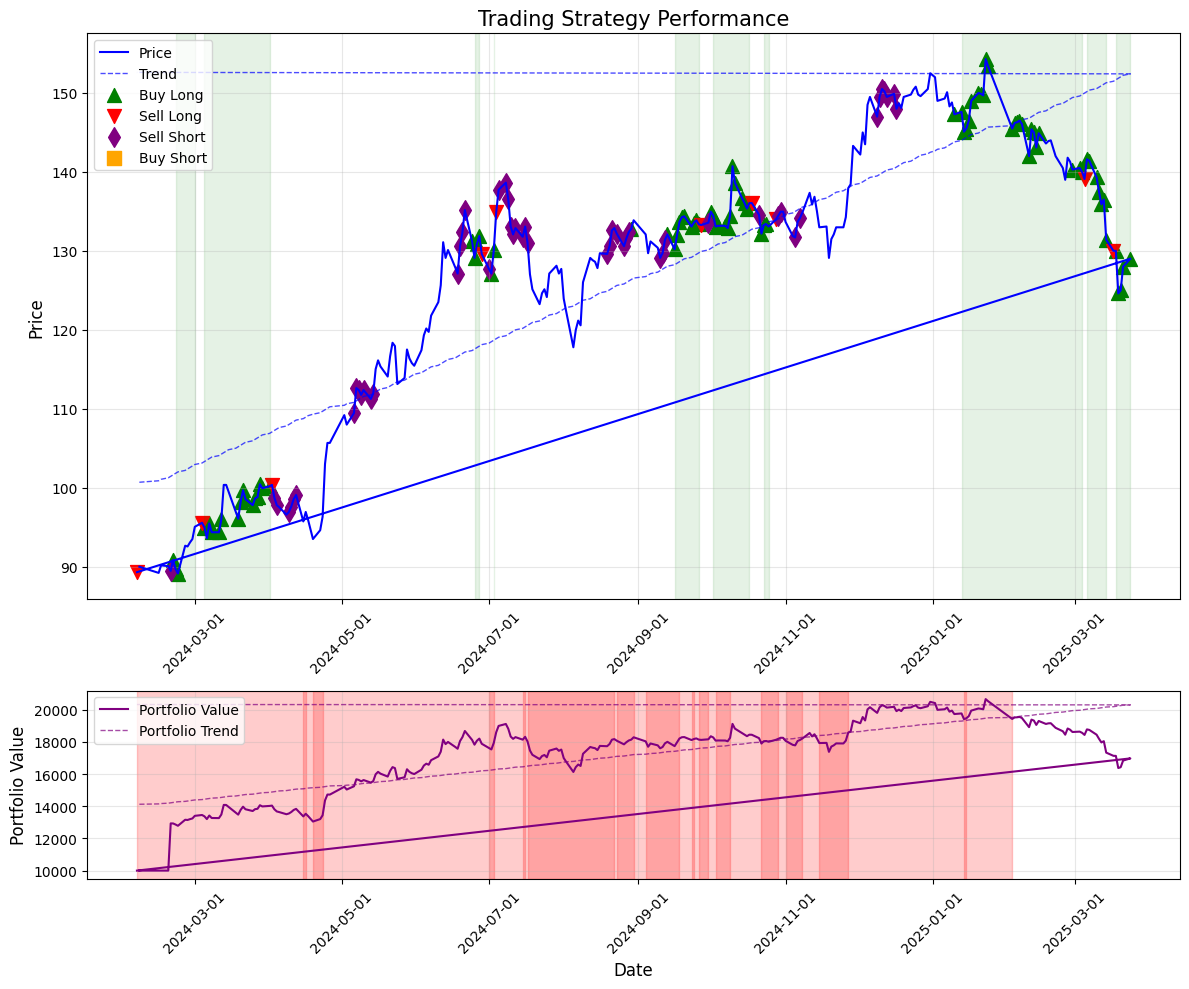

In [17]:
eval_env = VnStockEnv(
    df=df,
    window_size=25,
    frame_bound=(25, len(df)),
    initial_balance=10000,
    max_shares=150,
    render_mode=None  # Disable real-time rendering during evaluation
)

eval_env = Monitor(eval_env)
eval_env = DummyVecEnv([lambda: eval_env])

# Plot the trading strategy
fig = plot_trading_strategy(eval_env, model, df)